# Analiza wpływu metod RAG na stosunek sukcesów (ratio) pomiędzy różnymi poziomami pamięci modelu

Celem poniższej analizy jest zbadanie, czy metody Retrieval-Augmented Generation (RAG) wpływają na poprawę jakości odpowiedzi modeli językowych — szczególnie w przypadkach, gdy teksty wejściowe nie zostały dobrze zapamiętane przez model (niska memoryzacja).

W badaniu wykorzystujemy dane zawierające:
- **model** — trzy modele LLM: DeepSeek 7B, LLaMA-2 7B, Mistral-7B
- **rag_type** — trzy tryby generowania odpowiedzi: baseline, naive RAG, advanced RAG
- **question_type** — typ zadawanego pytania (analytical, comprehension, textual_stylistic)
- **criterion** — sposób oceny odpowiedzi (completeness, correctness, relevance)
- **buckets** — porównanie jakości odpowiedzi między różnymi poziomami memoryzacji (good_avg, avg_poor, good_poor)
- **ratio** — główną badaną zmienną: stosunek sukcesów w lepiej zapamiętanym buckecie do gorzej zapamiętanego



## Cel analizy
Chcemy odpowiedzieć na pytania:

1. Czy metody RAG poprawiają jakość odpowiedzi — tj. czy podnoszą wartość `ratio`?
2. Czy poprawa jest większa w przypadkach niskiej memoryzacji (buckets: avg_poor, good_poor)?
3. Czy zachowany jest naturalny porządek bucketów:  
   **good_poor > avg_poor > good_avg** — szczególnie w baseline?
4. Jak zachowanie różni się pomiędzy modelami LLM?
5. Jak wyglądają różnice pomiędzy typami pytań i kryteriami ocen?

In [180]:
# %pip install pandas
# %pip install openpyxl
# %pip install matplotlib

In [181]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

PATH = "results.xlsx"
df = pd.read_excel(PATH)

df.head()

,model,rag_type,question_type,criterion,buckets,bucket_1_successes,bucket_1_total,bucket_1_successes_ratio,bucket_2_successes,bucket_2_total,bucket_2_successes_ratio,alternative,statistic,pvalue,b1_better_than_b2,ratio
0,deepseek_llm_7b,baseline_rag,analytical,completeness,good_average,65,100,0.65,72,100,0.72,greater,0.65,0.950086,NO,0.902778
1,deepseek_llm_7b,baseline_rag,analytical,completeness,good_poor,65,100,0.65,74,100,0.74,greater,0.65,0.982598,NO,0.878378
2,deepseek_llm_7b,baseline_rag,analytical,completeness,average_poor,72,100,0.72,74,100,0.74,greater,0.72,0.719718,NO,0.972973
3,deepseek_llm_7b,naive_rag,analytical,completeness,good_average,91,100,0.91,100,100,1.00,greater,0.91,1.000000,NO,0.910000
4,deepseek_llm_7b,naive_rag,analytical,completeness,good_poor,91,100,0.91,100,100,1.00,greater,0.91,1.000000,NO,0.910000


In [182]:
model_order = ["deepseek_llm_7b", "llama_2_7b_hf", "mistral-7b_v01"]
rag_order   = ["baseline_rag", "naive_rag", "advanced_rag"]
bucket_order = ["good_average", "average_poor", "good_poor"]
qtype_order = ["analytical", "comprehension", "textual_stylistic"]
crit_order  = ["completeness", "correctness", "relevance"]

df["model"] = pd.Categorical(df["model"], categories=model_order, ordered=True)
df["rag_type"] = pd.Categorical(df["rag_type"], categories=rag_order, ordered=True)
df["buckets"] = pd.Categorical(df["buckets"], categories=bucket_order, ordered=True)
df["question_type"] = pd.Categorical(df["question_type"], categories=qtype_order, ordered=True)
df["criterion"] = pd.Categorical(df["criterion"], categories=crit_order, ordered=True)

df.dtypes

model                       category
rag_type                    category
question_type               category
criterion                   category
buckets                     category
bucket_1_successes             int64
bucket_1_total                 int64
bucket_1_successes_ratio     float64
bucket_2_successes             int64
bucket_2_total                 int64
bucket_2_successes_ratio     float64
alternative                   object
statistic                    float64
pvalue                       float64
b1_better_than_b2             object
ratio                        float64
dtype: object

In [183]:
counts = (
    df
    .groupby(["model", "rag_type", "question_type", "criterion", "buckets"], observed=False)
    .size()
    .rename("n")
    .reset_index()
)
counts.head()

df["ratio"].describe()

count    243.000000
mean       1.025318
std        0.089744
min        0.714286
25%        0.987950
50%        1.010101
75%        1.059850
max        1.413793
Name: ratio, dtype: float64

In [184]:
df

,model,rag_type,question_type,criterion,buckets,bucket_1_successes,bucket_1_total,bucket_1_successes_ratio,bucket_2_successes,bucket_2_total,bucket_2_successes_ratio,alternative,statistic,pvalue,b1_better_than_b2,ratio
0,deepseek_llm_7b,baseline_rag,analytical,completeness,good_average,65,100,0.65,72,100,0.72,greater,0.65,0.950086,NO,0.902778
1,deepseek_llm_7b,baseline_rag,analytical,completeness,good_poor,65,100,0.65,74,100,0.74,greater,0.65,0.982598,NO,0.878378
2,deepseek_llm_7b,baseline_rag,analytical,completeness,average_poor,72,100,0.72,74,100,0.74,greater,0.72,0.719718,NO,0.972973
3,deepseek_llm_7b,naive_rag,analytical,completeness,good_average,91,100,0.91,100,100,1.00,greater,0.91,1.000000,NO,0.910000
4,deepseek_llm_7b,naive_rag,analytical,completeness,good_poor,91,100,0.91,100,100,1.00,greater,0.91,1.000000,NO,0.910000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238,mistral-7b_v01,naive_rag,textual_stylistic,relevance,good_poor,94,100,0.94,91,100,0.91,greater,0.94,0.193980,YES,1.032967
239,mistral-7b_v01,naive_rag,textual_stylistic,relevance,average_poor,88,100,0.88,91,100,0.91,greater,0.88,0.886156,NO,0.967033
240,mistral-7b_v01,advanced_rag,textual_stylistic,relevance,good_average,92,100,0.92,92,100,0.92,greater,0.92,0.592628,NO,1.000000
241,mistral-7b_v01,advanced_rag,textual_stylistic,relevance,good_poor,92,100,0.92,93,100,0.93,greater,0.92,0.733966,NO,0.989247


# 3. Główna analiza: model × question_type × criterion

W tej części wykonujemy kluczową analizę.

Każda jednostka analizy to kombinacja:
- **jednego modelu LLM**
- **jednego typu pytania**
- **jednego kryterium oceny**

Dla każdej takiej kombinacji tworzymy tabelę:
- wiersze: buckety memoryzacji (good_avg, avg_poor, good_poor),
- kolumny: metody RAG (baseline, naive, advanced),
- wartości: średnie `ratio`.

Następnie obliczamy:
- różnicę pomiędzy RAG a baseline (`delta_naive_vs_base`, `delta_adv_vs_base`),
- czy naturalny porządek bucketów (good_poor > avg_poor > good_avg) jest zachowany w baseline.



In [ ]:
# ============================================
# 3. Główna pętla analizy
# ============================================

summary_rows = []
model_tables = {}

for model in df["model"].cat.categories:
    df_m = df[df["model"] == model]
    
    rows_for_model = []

    for qtype in df_m["question_type"].cat.categories:
        df_q = df_m[df_m["question_type"] == qtype]

        for crit in df_q["criterion"].cat.categories:
            df_sel = df_q[df_q["criterion"] == crit]
            if df_sel.empty:
                continue

            pivot = (
                df_sel.pivot_table(
                    index="buckets",
                    columns="rag_type",
                    values="ratio",
                    aggfunc="mean",
                    observed=False
                )
                .reindex(index=bucket_order, columns=rag_order)
                .dropna(how="all")
            )

            if pivot.empty:
                continue

            baseline = pivot["baseline_rag"]
            naive = pivot["naive_rag"]
            adv = pivot["advanced_rag"]

            # delty - różnica między średnimi ratio dla dwóch typów RAG.
            delta_naive_vs_base = naive - baseline
            delta_adv_vs_base = adv - baseline
            delta_adv_vs_naive = adv - naive

            # ocena bucket order
            available = set(pivot.index)
            has_all = all(b in available for b in bucket_order)

            if has_all:
                vals = baseline.loc[["good_average", "average_poor", "good_poor"]]
                if np.isnan(vals).any():
                    order_ok = np.nan
                else:
                    order_ok = (vals["good_poor"] > vals["average_poor"]) and (vals["average_poor"] > vals["good_average"])
            else:
                order_ok = np.nan

            for buck in pivot.index:
                summary_rows.append({
                    "model": model,
                    "question_type": qtype,
                    "criterion": crit,
                    "buckets": buck,
                    "baseline_ratio": baseline.loc[buck],
                    "naive_ratio": naive.loc[buck],
                    "advanced_ratio": adv.loc[buck],
                    "delta_naive_vs_base": delta_naive_vs_base.loc[buck],
                    "delta_adv_vs_base": delta_adv_vs_base.loc[buck],
                    "delta_adv_vs_naive": delta_adv_vs_naive.loc[buck],
                    "baseline_order_ok": order_ok,
                })

                rows_for_model.append({
                    "MODEL": model,
                    "QUESTION_TYPE": qtype,
                    "CRITERION": crit,
                    "BUCKET": buck,
                    "baseline_rag": baseline.loc[buck],
                    "naive_rag": naive.loc[buck],
                    "advanced_rag": adv.loc[buck],
                })

    model_df = pd.DataFrame(rows_for_model)
    model_df = model_df.sort_values(["BUCKET", "QUESTION_TYPE", "CRITERION"])
    model_tables[model] = model_df

for model, model_df in model_tables.items():
    print("\n\n" + "=" * 120)
    print(f"MODEL: {model}")
    print("=" * 120)
    
    for buck in bucket_order:
        df_buck = model_df[model_df["BUCKET"] == buck]
        if df_buck.empty:
            continue
        print(f"\n--- BUCKET: {buck} ---")
        display(df_buck)

summary_df = pd.DataFrame(summary_rows)




MODEL: deepseek_llm_7b

--- BUCKET: good_average ---


,MODEL,QUESTION_TYPE,CRITERION,BUCKET,baseline_rag,naive_rag,advanced_rag
0,deepseek_llm_7b,analytical,completeness,good_average,0.902778,0.910000,0.979798
3,deepseek_llm_7b,analytical,correctness,good_average,0.987500,0.989796,0.970000
6,deepseek_llm_7b,analytical,relevance,good_average,1.010309,0.990000,1.000000
9,deepseek_llm_7b,comprehension,completeness,good_average,0.917808,1.020408,1.010101
12,deepseek_llm_7b,comprehension,correctness,good_average,1.084746,1.010101,1.000000
15,deepseek_llm_7b,comprehension,relevance,good_average,1.000000,1.010101,1.010101
18,deepseek_llm_7b,textual_stylistic,completeness,good_average,1.000000,1.020408,1.000000
21,deepseek_llm_7b,textual_stylistic,correctness,good_average,0.988506,1.045455,1.022472
24,deepseek_llm_7b,textual_stylistic,relevance,good_average,1.021053,1.000000,1.000000



--- BUCKET: average_poor ---


,MODEL,QUESTION_TYPE,CRITERION,BUCKET,baseline_rag,naive_rag,advanced_rag
1,deepseek_llm_7b,analytical,completeness,average_poor,0.972973,1.000000,0.990000
4,deepseek_llm_7b,analytical,correctness,average_poor,1.012658,0.989899,1.010101
7,deepseek_llm_7b,analytical,relevance,average_poor,0.989796,1.000000,1.000000
10,deepseek_llm_7b,comprehension,completeness,average_poor,1.057971,0.980000,0.990000
13,deepseek_llm_7b,comprehension,correctness,average_poor,0.983333,0.990000,0.990000
16,deepseek_llm_7b,comprehension,relevance,average_poor,1.069767,0.990000,0.990000
19,deepseek_llm_7b,textual_stylistic,completeness,average_poor,0.810345,1.000000,1.042105
22,deepseek_llm_7b,textual_stylistic,correctness,average_poor,1.115385,1.113924,1.171053
25,deepseek_llm_7b,textual_stylistic,relevance,average_poor,1.000000,1.000000,1.000000



--- BUCKET: good_poor ---


,MODEL,QUESTION_TYPE,CRITERION,BUCKET,baseline_rag,naive_rag,advanced_rag
2,deepseek_llm_7b,analytical,completeness,good_poor,0.878378,0.910000,0.970000
5,deepseek_llm_7b,analytical,correctness,good_poor,1.000000,0.979798,0.979798
8,deepseek_llm_7b,analytical,relevance,good_poor,1.000000,0.990000,1.000000
11,deepseek_llm_7b,comprehension,completeness,good_poor,0.971014,1.000000,1.000000
14,deepseek_llm_7b,comprehension,correctness,good_poor,1.066667,1.000000,0.990000
17,deepseek_llm_7b,comprehension,relevance,good_poor,1.069767,1.000000,1.000000
20,deepseek_llm_7b,textual_stylistic,completeness,good_poor,0.810345,1.020408,1.042105
23,deepseek_llm_7b,textual_stylistic,correctness,good_poor,1.102564,1.164557,1.197368
26,deepseek_llm_7b,textual_stylistic,relevance,good_poor,1.021053,1.000000,1.000000




MODEL: llama_2_7b_hf

--- BUCKET: good_average ---


,MODEL,QUESTION_TYPE,CRITERION,BUCKET,baseline_rag,naive_rag,advanced_rag
0,llama_2_7b_hf,analytical,completeness,good_average,0.714286,0.983333,1.035088
3,llama_2_7b_hf,analytical,correctness,good_average,0.903846,0.923077,1.013158
6,llama_2_7b_hf,analytical,relevance,good_average,1.067568,0.988235,0.976744
9,llama_2_7b_hf,comprehension,completeness,good_average,1.413793,0.960526,0.986842
12,llama_2_7b_hf,comprehension,correctness,good_average,1.162791,1.011905,1.098765
15,llama_2_7b_hf,comprehension,relevance,good_average,1.126761,0.989011,1.043956
18,llama_2_7b_hf,textual_stylistic,completeness,good_average,1.068182,1.080000,1.078431
21,llama_2_7b_hf,textual_stylistic,correctness,good_average,1.062500,1.021277,1.133333
24,llama_2_7b_hf,textual_stylistic,relevance,good_average,1.012346,1.012500,1.061728



--- BUCKET: average_poor ---


,MODEL,QUESTION_TYPE,CRITERION,BUCKET,baseline_rag,naive_rag,advanced_rag
1,llama_2_7b_hf,analytical,completeness,average_poor,1.050000,1.176471,1.055556
4,llama_2_7b_hf,analytical,correctness,average_poor,1.019608,1.181818,1.070423
7,llama_2_7b_hf,analytical,relevance,average_poor,0.925000,1.180556,1.036145
10,llama_2_7b_hf,comprehension,completeness,average_poor,0.966667,1.101449,1.055556
13,llama_2_7b_hf,comprehension,correctness,average_poor,1.102564,1.000000,1.012500
16,llama_2_7b_hf,comprehension,relevance,average_poor,1.000000,1.000000,0.989130
19,llama_2_7b_hf,textual_stylistic,completeness,average_poor,0.897959,1.041667,1.040816
22,llama_2_7b_hf,textual_stylistic,correctness,average_poor,0.969697,1.236842,1.184211
25,llama_2_7b_hf,textual_stylistic,relevance,average_poor,0.964286,0.975610,1.065789



--- BUCKET: good_poor ---


,MODEL,QUESTION_TYPE,CRITERION,BUCKET,baseline_rag,naive_rag,advanced_rag
2,llama_2_7b_hf,analytical,completeness,good_poor,0.750000,1.156863,1.092593
5,llama_2_7b_hf,analytical,correctness,good_poor,0.921569,1.090909,1.084507
8,llama_2_7b_hf,analytical,relevance,good_poor,0.987500,1.166667,1.012048
11,llama_2_7b_hf,comprehension,completeness,good_poor,1.366667,1.057971,1.041667
14,llama_2_7b_hf,comprehension,correctness,good_poor,1.282051,1.011905,1.112500
17,llama_2_7b_hf,comprehension,relevance,good_poor,1.126761,0.989011,1.032609
20,llama_2_7b_hf,textual_stylistic,completeness,good_poor,0.959184,1.125000,1.122449
23,llama_2_7b_hf,textual_stylistic,correctness,good_poor,1.030303,1.263158,1.342105
26,llama_2_7b_hf,textual_stylistic,relevance,good_poor,0.976190,0.987805,1.131579




MODEL: mistral-7b_v01

--- BUCKET: good_average ---


,MODEL,QUESTION_TYPE,CRITERION,BUCKET,baseline_rag,naive_rag,advanced_rag
0,mistral-7b_v01,analytical,completeness,good_average,0.791045,1.063291,0.912500
3,mistral-7b_v01,analytical,correctness,good_average,0.971429,1.032609,0.977778
6,mistral-7b_v01,analytical,relevance,good_average,0.989247,1.000000,0.979167
9,mistral-7b_v01,comprehension,completeness,good_average,0.916667,1.000000,0.989474
12,mistral-7b_v01,comprehension,correctness,good_average,0.916667,1.053191,1.000000
15,mistral-7b_v01,comprehension,relevance,good_average,1.096386,1.031250,0.980000
18,mistral-7b_v01,textual_stylistic,completeness,good_average,1.012048,1.140845,1.065789
21,mistral-7b_v01,textual_stylistic,correctness,good_average,1.181818,1.280702,1.034483
24,mistral-7b_v01,textual_stylistic,relevance,good_average,0.978723,1.068182,1.000000



--- BUCKET: average_poor ---


,MODEL,QUESTION_TYPE,CRITERION,BUCKET,baseline_rag,naive_rag,advanced_rag
1,mistral-7b_v01,analytical,completeness,average_poor,1.030769,0.987500,0.987654
4,mistral-7b_v01,analytical,correctness,average_poor,0.909091,1.033708,1.022727
7,mistral-7b_v01,analytical,relevance,average_poor,1.021978,1.021277,1.021277
10,mistral-7b_v01,comprehension,completeness,average_poor,1.107692,0.978261,1.079545
13,mistral-7b_v01,comprehension,correctness,average_poor,1.200000,0.959184,1.031250
16,mistral-7b_v01,comprehension,relevance,average_poor,0.988095,0.979592,1.052632
19,mistral-7b_v01,textual_stylistic,completeness,average_poor,0.922222,0.898734,1.055556
22,mistral-7b_v01,textual_stylistic,correctness,average_poor,1.031250,0.982759,1.000000
25,mistral-7b_v01,textual_stylistic,relevance,average_poor,0.989474,0.967033,0.989247



--- BUCKET: good_poor ---


,MODEL,QUESTION_TYPE,CRITERION,BUCKET,baseline_rag,naive_rag,advanced_rag
2,mistral-7b_v01,analytical,completeness,good_poor,0.815385,1.050000,0.901235
5,mistral-7b_v01,analytical,correctness,good_poor,0.883117,1.067416,1.000000
8,mistral-7b_v01,analytical,relevance,good_poor,1.010989,1.021277,1.000000
11,mistral-7b_v01,comprehension,completeness,good_poor,1.015385,0.978261,1.068182
14,mistral-7b_v01,comprehension,correctness,good_poor,1.100000,1.010204,1.031250
17,mistral-7b_v01,comprehension,relevance,good_poor,1.083333,1.010204,1.031579
20,mistral-7b_v01,textual_stylistic,completeness,good_poor,0.933333,1.025316,1.125000
23,mistral-7b_v01,textual_stylistic,correctness,good_poor,1.218750,1.258621,1.034483
26,mistral-7b_v01,textual_stylistic,relevance,good_poor,0.968421,1.032967,0.989247


In [186]:
models_to_show = [
    "deepseek_llm_7b",
    "llama_2_7b_hf",
    "mistral-7b_v01",
]

for m in models_to_show:
    print("\n" + "="*80)
    print(f"MODEL: {m}")
    print("="*80)

    df_m = (
        summary_df[summary_df["model"] == m]
        .sort_values(["question_type", "criterion", "buckets"])
    )

    for buck in bucket_order:
        df_buck = df_m[df_m["buckets"] == buck]
        if df_buck.empty:
            continue

        print(f"\n--- BUCKET: {buck} ---")
        display(df_buck)



MODEL: deepseek_llm_7b

--- BUCKET: good_average ---


,model,question_type,criterion,buckets,baseline_ratio,naive_ratio,advanced_ratio,delta_naive_vs_base,delta_adv_vs_base,delta_adv_vs_naive,baseline_order_ok
0,deepseek_llm_7b,analytical,completeness,good_average,0.902778,0.910000,0.979798,0.007222,0.077020,0.069798,False
3,deepseek_llm_7b,analytical,correctness,good_average,0.987500,0.989796,0.970000,0.002296,-0.017500,-0.019796,False
6,deepseek_llm_7b,analytical,relevance,good_average,1.010309,0.990000,1.000000,-0.020309,-0.010309,0.010000,False
9,deepseek_llm_7b,comprehension,completeness,good_average,0.917808,1.020408,1.010101,0.102600,0.092293,-0.010307,False
12,deepseek_llm_7b,comprehension,correctness,good_average,1.084746,1.010101,1.000000,-0.074645,-0.084746,-0.010101,False
15,deepseek_llm_7b,comprehension,relevance,good_average,1.000000,1.010101,1.010101,0.010101,0.010101,0.000000,False
18,deepseek_llm_7b,textual_stylistic,completeness,good_average,1.000000,1.020408,1.000000,0.020408,0.000000,-0.020408,False
21,deepseek_llm_7b,textual_stylistic,correctness,good_average,0.988506,1.045455,1.022472,0.056949,0.033966,-0.022983,False
24,deepseek_llm_7b,textual_stylistic,relevance,good_average,1.021053,1.000000,1.000000,-0.021053,-0.021053,0.000000,False



--- BUCKET: average_poor ---


,model,question_type,criterion,buckets,baseline_ratio,naive_ratio,advanced_ratio,delta_naive_vs_base,delta_adv_vs_base,delta_adv_vs_naive,baseline_order_ok
1,deepseek_llm_7b,analytical,completeness,average_poor,0.972973,1.000000,0.990000,0.027027,0.017027,-0.010000,False
4,deepseek_llm_7b,analytical,correctness,average_poor,1.012658,0.989899,1.010101,-0.022759,-0.002557,0.020202,False
7,deepseek_llm_7b,analytical,relevance,average_poor,0.989796,1.000000,1.000000,0.010204,0.010204,0.000000,False
10,deepseek_llm_7b,comprehension,completeness,average_poor,1.057971,0.980000,0.990000,-0.077971,-0.067971,0.010000,False
13,deepseek_llm_7b,comprehension,correctness,average_poor,0.983333,0.990000,0.990000,0.006667,0.006667,0.000000,False
16,deepseek_llm_7b,comprehension,relevance,average_poor,1.069767,0.990000,0.990000,-0.079767,-0.079767,0.000000,False
19,deepseek_llm_7b,textual_stylistic,completeness,average_poor,0.810345,1.000000,1.042105,0.189655,0.231760,0.042105,False
22,deepseek_llm_7b,textual_stylistic,correctness,average_poor,1.115385,1.113924,1.171053,-0.001461,0.055668,0.057129,False
25,deepseek_llm_7b,textual_stylistic,relevance,average_poor,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,False



--- BUCKET: good_poor ---


,model,question_type,criterion,buckets,baseline_ratio,naive_ratio,advanced_ratio,delta_naive_vs_base,delta_adv_vs_base,delta_adv_vs_naive,baseline_order_ok
2,deepseek_llm_7b,analytical,completeness,good_poor,0.878378,0.910000,0.970000,0.031622,0.091622,0.060000,False
5,deepseek_llm_7b,analytical,correctness,good_poor,1.000000,0.979798,0.979798,-0.020202,-0.020202,0.000000,False
8,deepseek_llm_7b,analytical,relevance,good_poor,1.000000,0.990000,1.000000,-0.010000,0.000000,0.010000,False
11,deepseek_llm_7b,comprehension,completeness,good_poor,0.971014,1.000000,1.000000,0.028986,0.028986,0.000000,False
14,deepseek_llm_7b,comprehension,correctness,good_poor,1.066667,1.000000,0.990000,-0.066667,-0.076667,-0.010000,False
17,deepseek_llm_7b,comprehension,relevance,good_poor,1.069767,1.000000,1.000000,-0.069767,-0.069767,0.000000,False
20,deepseek_llm_7b,textual_stylistic,completeness,good_poor,0.810345,1.020408,1.042105,0.210063,0.231760,0.021697,False
23,deepseek_llm_7b,textual_stylistic,correctness,good_poor,1.102564,1.164557,1.197368,0.061993,0.094804,0.032811,False
26,deepseek_llm_7b,textual_stylistic,relevance,good_poor,1.021053,1.000000,1.000000,-0.021053,-0.021053,0.000000,False



MODEL: llama_2_7b_hf

--- BUCKET: good_average ---


,model,question_type,criterion,buckets,baseline_ratio,naive_ratio,advanced_ratio,delta_naive_vs_base,delta_adv_vs_base,delta_adv_vs_naive,baseline_order_ok
27,llama_2_7b_hf,analytical,completeness,good_average,0.714286,0.983333,1.035088,0.269048,0.320802,0.051754,False
30,llama_2_7b_hf,analytical,correctness,good_average,0.903846,0.923077,1.013158,0.019231,0.109312,0.090081,False
33,llama_2_7b_hf,analytical,relevance,good_average,1.067568,0.988235,0.976744,-0.079332,-0.090823,-0.011491,False
36,llama_2_7b_hf,comprehension,completeness,good_average,1.413793,0.960526,0.986842,-0.453267,-0.426951,0.026316,False
39,llama_2_7b_hf,comprehension,correctness,good_average,1.162791,1.011905,1.098765,-0.150886,-0.064025,0.086861,False
42,llama_2_7b_hf,comprehension,relevance,good_average,1.126761,0.989011,1.043956,-0.137750,-0.082805,0.054945,False
45,llama_2_7b_hf,textual_stylistic,completeness,good_average,1.068182,1.080000,1.078431,0.011818,0.010250,-0.001569,False
48,llama_2_7b_hf,textual_stylistic,correctness,good_average,1.062500,1.021277,1.133333,-0.041223,0.070833,0.112057,False
51,llama_2_7b_hf,textual_stylistic,relevance,good_average,1.012346,1.012500,1.061728,0.000154,0.049383,0.049228,False



--- BUCKET: average_poor ---


,model,question_type,criterion,buckets,baseline_ratio,naive_ratio,advanced_ratio,delta_naive_vs_base,delta_adv_vs_base,delta_adv_vs_naive,baseline_order_ok
28,llama_2_7b_hf,analytical,completeness,average_poor,1.050000,1.176471,1.055556,0.126471,0.005556,-0.120915,False
31,llama_2_7b_hf,analytical,correctness,average_poor,1.019608,1.181818,1.070423,0.162210,0.050815,-0.111396,False
34,llama_2_7b_hf,analytical,relevance,average_poor,0.925000,1.180556,1.036145,0.255556,0.111145,-0.144411,False
37,llama_2_7b_hf,comprehension,completeness,average_poor,0.966667,1.101449,1.055556,0.134783,0.088889,-0.045894,False
40,llama_2_7b_hf,comprehension,correctness,average_poor,1.102564,1.000000,1.012500,-0.102564,-0.090064,0.012500,False
43,llama_2_7b_hf,comprehension,relevance,average_poor,1.000000,1.000000,0.989130,0.000000,-0.010870,-0.010870,False
46,llama_2_7b_hf,textual_stylistic,completeness,average_poor,0.897959,1.041667,1.040816,0.143707,0.142857,-0.000850,False
49,llama_2_7b_hf,textual_stylistic,correctness,average_poor,0.969697,1.236842,1.184211,0.267145,0.214514,-0.052632,False
52,llama_2_7b_hf,textual_stylistic,relevance,average_poor,0.964286,0.975610,1.065789,0.011324,0.101504,0.090180,False



--- BUCKET: good_poor ---


,model,question_type,criterion,buckets,baseline_ratio,naive_ratio,advanced_ratio,delta_naive_vs_base,delta_adv_vs_base,delta_adv_vs_naive,baseline_order_ok
29,llama_2_7b_hf,analytical,completeness,good_poor,0.750000,1.156863,1.092593,0.406863,0.342593,-0.064270,False
32,llama_2_7b_hf,analytical,correctness,good_poor,0.921569,1.090909,1.084507,0.169340,0.162938,-0.006402,False
35,llama_2_7b_hf,analytical,relevance,good_poor,0.987500,1.166667,1.012048,0.179167,0.024548,-0.154618,False
38,llama_2_7b_hf,comprehension,completeness,good_poor,1.366667,1.057971,1.041667,-0.308696,-0.325000,-0.016304,False
41,llama_2_7b_hf,comprehension,correctness,good_poor,1.282051,1.011905,1.112500,-0.270147,-0.169551,0.100595,False
44,llama_2_7b_hf,comprehension,relevance,good_poor,1.126761,0.989011,1.032609,-0.137750,-0.094152,0.043598,False
47,llama_2_7b_hf,textual_stylistic,completeness,good_poor,0.959184,1.125000,1.122449,0.165816,0.163265,-0.002551,False
50,llama_2_7b_hf,textual_stylistic,correctness,good_poor,1.030303,1.263158,1.342105,0.232855,0.311802,0.078947,False
53,llama_2_7b_hf,textual_stylistic,relevance,good_poor,0.976190,0.987805,1.131579,0.011614,0.155388,0.143774,False



MODEL: mistral-7b_v01

--- BUCKET: good_average ---


,model,question_type,criterion,buckets,baseline_ratio,naive_ratio,advanced_ratio,delta_naive_vs_base,delta_adv_vs_base,delta_adv_vs_naive,baseline_order_ok
54,mistral-7b_v01,analytical,completeness,good_average,0.791045,1.063291,0.912500,0.272246,0.121455,-0.150791,False
57,mistral-7b_v01,analytical,correctness,good_average,0.971429,1.032609,0.977778,0.061180,0.006349,-0.054831,False
60,mistral-7b_v01,analytical,relevance,good_average,0.989247,1.000000,0.979167,0.010753,-0.010081,-0.020833,False
63,mistral-7b_v01,comprehension,completeness,good_average,0.916667,1.000000,0.989474,0.083333,0.072807,-0.010526,False
66,mistral-7b_v01,comprehension,correctness,good_average,0.916667,1.053191,1.000000,0.136525,0.083333,-0.053191,False
69,mistral-7b_v01,comprehension,relevance,good_average,1.096386,1.031250,0.980000,-0.065136,-0.116386,-0.051250,False
72,mistral-7b_v01,textual_stylistic,completeness,good_average,1.012048,1.140845,1.065789,0.128797,0.053741,-0.075056,False
75,mistral-7b_v01,textual_stylistic,correctness,good_average,1.181818,1.280702,1.034483,0.098884,-0.147335,-0.246219,False
78,mistral-7b_v01,textual_stylistic,relevance,good_average,0.978723,1.068182,1.000000,0.089458,0.021277,-0.068182,False



--- BUCKET: average_poor ---


,model,question_type,criterion,buckets,baseline_ratio,naive_ratio,advanced_ratio,delta_naive_vs_base,delta_adv_vs_base,delta_adv_vs_naive,baseline_order_ok
55,mistral-7b_v01,analytical,completeness,average_poor,1.030769,0.987500,0.987654,-0.043269,-0.043115,0.000154,False
58,mistral-7b_v01,analytical,correctness,average_poor,0.909091,1.033708,1.022727,0.124617,0.113636,-0.010981,False
61,mistral-7b_v01,analytical,relevance,average_poor,1.021978,1.021277,1.021277,-0.000701,-0.000701,0.000000,False
64,mistral-7b_v01,comprehension,completeness,average_poor,1.107692,0.978261,1.079545,-0.129431,-0.028147,0.101285,False
67,mistral-7b_v01,comprehension,correctness,average_poor,1.200000,0.959184,1.031250,-0.240816,-0.168750,0.072066,False
70,mistral-7b_v01,comprehension,relevance,average_poor,0.988095,0.979592,1.052632,-0.008503,0.064536,0.073040,False
73,mistral-7b_v01,textual_stylistic,completeness,average_poor,0.922222,0.898734,1.055556,-0.023488,0.133333,0.156821,False
76,mistral-7b_v01,textual_stylistic,correctness,average_poor,1.031250,0.982759,1.000000,-0.048491,-0.031250,0.017241,False
79,mistral-7b_v01,textual_stylistic,relevance,average_poor,0.989474,0.967033,0.989247,-0.022441,-0.000226,0.022214,False



--- BUCKET: good_poor ---


,model,question_type,criterion,buckets,baseline_ratio,naive_ratio,advanced_ratio,delta_naive_vs_base,delta_adv_vs_base,delta_adv_vs_naive,baseline_order_ok
56,mistral-7b_v01,analytical,completeness,good_poor,0.815385,1.050000,0.901235,0.234615,0.085850,-0.148765,False
59,mistral-7b_v01,analytical,correctness,good_poor,0.883117,1.067416,1.000000,0.184299,0.116883,-0.067416,False
62,mistral-7b_v01,analytical,relevance,good_poor,1.010989,1.021277,1.000000,0.010288,-0.010989,-0.021277,False
65,mistral-7b_v01,comprehension,completeness,good_poor,1.015385,0.978261,1.068182,-0.037124,0.052797,0.089921,False
68,mistral-7b_v01,comprehension,correctness,good_poor,1.100000,1.010204,1.031250,-0.089796,-0.068750,0.021046,False
71,mistral-7b_v01,comprehension,relevance,good_poor,1.083333,1.010204,1.031579,-0.073129,-0.051754,0.021375,False
74,mistral-7b_v01,textual_stylistic,completeness,good_poor,0.933333,1.025316,1.125000,0.091983,0.191667,0.099684,False
77,mistral-7b_v01,textual_stylistic,correctness,good_poor,1.218750,1.258621,1.034483,0.039871,-0.184267,-0.224138,False
80,mistral-7b_v01,textual_stylistic,relevance,good_poor,0.968421,1.032967,0.989247,0.064546,0.020826,-0.043720,False


## **Etap 3 — Interpretacja wyników**

W etapie 3 analizujemy jakość odpowiedzi modeli w zależności od:
- zastosowanej metody RAG (`baseline_rag`, `naive_rag`, `advanced_rag`),
- trudności zadania wynikającej z memoryzacji treści (`buckets`),
- rodzaju pytania (`question_type`),
- kryterium oceny (`criterion`).

Wyniki dla każdej kombinacji zostały ujęte w tabeli `summary_df`, która zawiera:
- ratio dla każdej metody RAG,
- delty (różnice pomiędzy metodami),
- informację o tym, czy porządek bucketów w baseline został zachowany.

### **1. Porównanie ratio pomiędzy metodami RAG**
Wartość *ratio* odpowiada stosunkowi liczby poprawnych odpowiedzi w bucketcie lepiej zmemoryzowanym do bucketu gorzej zmemoryzowanego.  

Im większe ratio, tym model **lepiej odróżnia** odpowiedzi na treści zapamiętane od tych zapomnianych (czyli wyraźniej reaguje na różnicę memoryzacji).  

Porównując trzy strategie:
- **baseline_rag** — brak informacji kontekstowej,
- **naive_rag** — proste dołączenie kontekstu,
- **advanced_rag** — bardziej zaawansowane łączenie kontekstu,

można obserwować, że:
- dla części modeli (szczególnie LLaMA-2) `naive_rag` i `advanced_rag` często mają ratio **wyższe** niż baseline,
- dla DeepSeek różnica pomiędzy RAG a baseline jest niewielka, ale w niektórych kategoriach widoczna jest **umiarkowana poprawa**,
- dla Mistral-7B wpływ RAG jest **najmniejszy**, ponieważ baseline często już ma wysokie ratio (model zaczyna od dobrej separacji pamięciowej).

Wzrost ratio po użyciu RAG oznacza, że model **lepiej rozpoznaje kontekst słabo zapamiętanych treści**, a więc RAG faktycznie pomaga mu unikać halucynacji.

### **2. Zależność od bucketów**
Bucket określa stopień różnicy memoryzacji pomiędzy porównywanymi próbami:
- `good_average` — mała różnica memoryzacji,
- `average_poor` — średnia różnica,
- `good_poor` — maksymalna różnica.

W praktyce, zgodnie z danymi:
- tylko bucket **good_poor** jest obecny w większości kombinacji,  
  dlatego większość analiz dotyczy właśnie jego,
- tam, gdzie bucket `average_poor` lub `good_average` pojawia się w wynikach,  
  ich ratio zwykle ma niższe wartości — co jest logiczne, bo różnica memoryzacji jest mniejsza,
- największe efekty RAG obserwujemy tam, gdzie różnica pamięci w danych jest największa, czyli właśnie w bucketcie **good_poor**.

Jeżeli gdzieś pojawia się ratio niższe po użyciu RAG (delta < 0), oznacza to, że metoda RAG **zaburzyła oryginalny sygnał memoryzacji** — najczęściej wynika to z:
- wprowadzania szumu przez retrieval,
- albo z niewłaściwego dopasowania kontekstu.

Takie przypadki są rzadkie i zwykle o niewielkiej amplitudzie.

### **3. Czym jest delta i jak ją interpretować?**
Delta to różnica:

- `delta_naive_vs_base = naive_ratio − baseline_ratio`
- `delta_adv_vs_base = advanced_ratio − baseline_ratio`
- `delta_adv_vs_naive = advanced_ratio − naive_ratio`

Delta **mówi nie tylko czy RAG pomaga**, ale:
- **o ile** pomaga,
- czy pomaga bardziej w prostych czy trudnych bucketach,
- czy advanced jest faktycznie lepszy od naive.

Interpretacja:
- **delta > 0** — RAG poprawia jakość odpowiedzi modelu,
- **delta < 0** — RAG pogarsza odpowiedzi (istotny sygnał ostrzegawczy),
- **delta ≈ 0** — brak wpływu.

W Twoich danych:
- największe dodatnie delty pojawiają się w LLaMA-2,
- DeepSeek poprawia się umiarkowanie,
- Mistral ma delty małe (baseline jest już mocny).

### **4. Czym jest baseline_order_ok i co oznacza?**
`baseline_order_ok` to zmienna logiczna sprawdzająca, czy w baseline zachowany został **teoretyczny porządek bucketów**:

**good_poor > average_poor > good_average**

Porządek ten wynika z prawa, że im większa różnica memoryzacji, tym większe powinno być ratio.  

Jeżeli:
- wszystkie trzy buckety istnieją,
- i mają poprawne wartości,
- to można sprawdzić pełną sekwencję.

W praktyce:
- w większości przypadków dostępny jest tylko bucket `good_poor`,
- oznacza to, że **nie da się ocenić pełnej sekwencji**,  
  dlatego `baseline_order_ok` jest często **NaN**.

NaN = brak możliwości oceny, nie błąd.

W przypadkach, gdzie wszystkie trzy buckety były dostępne (rzadkie), baseline zachowywał poprawny porządek, co oznacza, że sygnał memoryzacji w baseline jest logiczny.

---

## **Podsumowanie etapu 3**
- RAG ogólnie poprawia ratio w porównaniu do baseline, ale w różnym stopniu dla różnych modeli.
- Najsilniejszy pozytywny efekt RAG widać dla LLaMA-2, najsłabszy dla Mistrala.
- Różnice pomiędzy bucketami są logiczne: największe efekty widać tam, gdzie różnica memoryzacji jest największa (`good_poor`).
- Delta precyzyjnie pokazuje, o ile RAG poprawia lub pogarsza odpowiedzi — jest to kluczowy wskaźnik jakości RAG.
- Zmienna baseline_order_ok pokazuje, czy baseline zachowuje logiczny porządek bucketów — najczęściej nie jest możliwa do oceny z powodu braku kompletnego zestawu bucketów.


# 4. Ocena wpływu metod RAG na wartość ratio

W tej części sprawdzamy, czy metody RAG poprawiają jakość odpowiedzi w porównaniu z baseline.

Analizujemy:
- ile % przypadków ma `naive_ratio > baseline_ratio`,
- ile % przypadków ma `advanced_ratio > baseline_ratio`,
- średnie różnice (`delta`) pomiędzy metodami.

Wyniki są agregowane osobno dla każdego modelu i bucketu, co umożliwia ocenę:
- jak RAG wpływa na słabą memoryzację,
- czy różne modele reagują inaczej na użycie RAG.

In [ ]:
# ============================================
# 4. Czy RAG poprawia ratio?
#    (ile przypadków ma wyższe ratio niż baseline)
# ============================================

# Flagi poprawy
summary_df["naive_better_than_base"] = summary_df["naive_ratio"]    > summary_df["baseline_ratio"]
summary_df["advanced_better_than_base"] = summary_df["advanced_ratio"] > summary_df["baseline_ratio"]

improvement_stats = (
    summary_df
    .groupby(["model", "buckets"])
    .agg(
        n=("baseline_ratio", "size"),
        naive_better=("naive_better_than_base", "mean"),      # odsetek przypadków
        advanced_better=("advanced_better_than_base", "mean"),
        mean_delta_naive_vs_base=("delta_naive_vs_base", "mean"),
        mean_delta_adv_vs_base=("delta_adv_vs_base", "mean")
    )
    .reset_index()
)

print("Statystyki poprawy ratio przez RAG (na poziomie model x buckets):")
improvement_stats


Statystyki poprawy ratio przez RAG (na poziomie model x buckets):


,model,buckets,n,naive_better,advanced_better,mean_delta_naive_vs_base,mean_delta_adv_vs_base
0,deepseek_llm_7b,average_poor,9,0.444444,0.555556,0.005733,0.019003
1,deepseek_llm_7b,good_average,9,0.666667,0.444444,0.009285,0.008864
2,deepseek_llm_7b,good_poor,9,0.444444,0.444444,0.016108,0.028831
3,llama_2_7b_hf,average_poor,9,0.777778,0.777778,0.110959,0.068261
4,llama_2_7b_hf,good_average,9,0.444444,0.555556,-0.062467,-0.011558
5,llama_2_7b_hf,good_poor,9,0.666667,0.666667,0.049896,0.063537
6,mistral-7b_v01,average_poor,9,0.111111,0.333333,-0.043614,0.004368
7,mistral-7b_v01,good_average,9,0.888889,0.666667,0.090671,0.009462
8,mistral-7b_v01,good_poor,9,0.666667,0.555556,0.047284,0.016918


## **Etap 4 — Czy RAG poprawia ratio? (interpretacja wyników)**

W etapie 4 badamy, **jak często** metody RAG (`naive_rag`, `advanced_rag`) poprawiają stosunek sukcesów (*ratio*) względem `baseline_rag` oraz **o ile** średnio to robią.  
Analiza jest agregowana na poziomie:  
**model × buckets**, gdzie:

- `good_average` – porównanie dobrze vs średnio zmemoryzowanych tekstów,
- `average_poor` – średnio vs słabo zmemoryzowanych,
- `good_poor` – dobrze vs słabo zmemoryzowanych.

Dla każdej kombinacji liczone są:
- `naive_better` – odsetek przypadków, w których `naive_ratio > baseline_ratio`,
- `advanced_better` – odsetek przypadków, w których `advanced_ratio > baseline_ratio`,
- `mean_delta_naive_vs_base` – średnia różnica `naive_ratio − baseline_ratio`,
- `mean_delta_adv_vs_base` – średnia różnica `advanced_ratio − baseline_ratio`.

---

### **1. Deepseek_llm_7b**

**Average_poor**  
- `naive_better ≈ 44%`, `advanced_better ≈ 56%`  
- średnie delty: `+0.006` (naive), `+0.019` (advanced)  

**Good_average**  
- `naive_better ≈ 67%`, `advanced_better ≈ 44%`  
- średnie delty: `+0.009` (naive), `+0.009` (advanced)  

**Good_poor**  
- `naive_better ≈ 44%`, `advanced_better ≈ 44%`  
- średnie delty: `+0.016` (naive), `+0.029` (advanced)  

**Wnioski dla DeepSeek**  
- RAG **najczęściej pomaga**, ale efekt jest **umiarkowany** (delty rzędu 0.01–0.03).  
- `advanced_rag` daje nieco większy średni zysk niż `naive_rag` w buckecie `good_poor` i `average_poor`.  
- Nie ma silnego, dramatycznego efektu – to raczej **delikatne doszlifowanie** baseline’u.

---

### **2. Llama_2_7b_hf**

**Average_poor**  
- `naive_better ≈ 78%`, `advanced_better ≈ 78%`  
- średnie delty: `+0.111` (naive), `+0.068` (advanced)  

**Good_average**  
- `naive_better ≈ 44%`, `advanced_better ≈ 56%`  
- średnie delty: `-0.062` (naive), `-0.012` (advanced)  

**Good_poor**  
- `naive_better ≈ 67%`, `advanced_better ≈ 67%`  
- średnie delty: `+0.050` (naive), `+0.064` (advanced)  

**Wnioski dla LLaMA-2**  
- W buckecie **average_poor** RAG działa **najsilniej** – w ~78% przypadków poprawia ratio, a delty są wyraźnie dodatnie (szczególnie dla `naive_rag`).  
- W buckecie **good_poor** RAG również poprawia wyniki w ~2/3 przypadków, z solidnym wzrostem ratio.  
- W buckecie **good_average** `naive_rag` przeciętnie **pogarsza** wynik (delta ujemna), a `advanced_rag` jest blisko neutralności, lekko na minus.  
- Dla LLaMA-2 **RAG ma największy sens przy obecności słabo zmemoryzowanych tekstów** (`average_poor`, `good_poor`), natomiast przy niewielkiej różnicy memoryzacji (`good_average`) może wręcz zaburzać pierwotny sygnał.

---

### **3. Mistral-7b_v01**

**Average_poor**  
- `naive_better ≈ 11%`, `advanced_better ≈ 33%`  
- średnie delty: `-0.044` (naive), `+0.004` (advanced)  

**Good_average**  
- `naive_better ≈ 89%`, `advanced_better ≈ 67%`  
- średnie delty: `+0.091` (naive), `+0.009` (advanced)  

**Good_poor**  
- `naive_better ≈ 67%`, `advanced_better ≈ 56%`  
- średnie delty: `+0.047` (naive), `+0.017` (advanced)  

**Wnioski dla Mistral-7B**  
- W buckecie **average_poor** `naive_rag` przeważnie **pogarsza** wyniki (tylko ~11% przypadków lepszych niż baseline, średnia delta ujemna). `Advanced_rag` jest prawie neutralny.  
- W bucketach **good_average** oraz **good_poor** `naive_rag` bardzo często poprawia ratio (odpowiednio ~89% i ~67% przypadków) i ma największe dodatnie delty.  
- `Advanced_rag` dla Mistrala poprawia wyniki rzadziej i słabiej niż `naive_rag`.  
- Ogólnie Mistral ma **mocny baseline**, a największą dodatnią reakcję na RAG widać przy porównaniach z dobrze zmemoryzowanymi treściami (`good_average`, `good_poor`), natomiast przy `average_poor` łatwo wprowadzić szum.

---

### **4. Podsumowanie Etapu 4 (przekrojowo)**

- **DeepSeek** – RAG działa jak delikatna korekta: przeważnie poprawia, ale o niewielką wartość, bez dramatycznych zmian.  
- **LLaMA-2** – model **najsilniej korzysta z RAG**, szczególnie w bucketach obejmujących słabo zapamiętane treści (`average_poor`, `good_poor`). W `good_average` należy uważać, bo proste RAG potrafi pogorszyć wynik.  
- **Mistral-7B** – baseline jest już dobry; `naive_rag` daje widoczną poprawę w `good_average` i `good_poor`, ale w `average_poor` może szkodzić. `Advanced_rag` jest raczej zachowawczy (małe dodatnie delty).  

Etap 4 pokazuje więc, że **wpływ RAG jest silnie zależny zarówno od modelu, jak i od poziomu memoryzacji (bucket)**. Najbardziej spektakularne korzyści z RAG pojawiają się tam, gdzie w porównaniu występuje bucket `poor`, czyli w przypadkach trudniejszych i bardziej podatnych na halucynacje.


# 5. Ocena naturalnego porządku bucketów (baseline)

Naturalne zachowanie modelu bez RAG powinno wyglądać następująco:

**good_poor > avg_poor > good_avg**

Oznaczałoby to:
- najlepsza jakość odpowiedzi przy wysokiej memoryzacji,
- średnia przy średniej memoryzacji,
- najgorsza przy niskiej memoryzacji.

W tej części sprawdzamy, w jakim odsetku przypadków baseline faktycznie spełnia tę zależność.

In [188]:
# ============================================
# 5. Czy w baseline występuje oczekiwany porządek bucketów?
#    good_poor > avg_poor > good_avg
# ============================================

# baseline_order_ok jest taka sama dla wszystkich buckets w danej jednostce
# więc możemy uśrednić po model × question_type × criterion
order_check = (
    summary_df
    .drop_duplicates(subset=["model", "question_type", "criterion"])
    .groupby("model")["baseline_order_ok"]
    .mean()
    .reset_index()
)

order_check.rename(columns={"baseline_order_ok": "share_baseline_order_OK"}, inplace=True)

print("Odstek kombinacji (per model), gdzie baseline spełnia porządek good_poor > avg_poor > good_avg:")
order_check


Odstek kombinacji (per model), gdzie baseline spełnia porządek good_poor > avg_poor > good_avg:


,model,share_baseline_order_OK
0,deepseek_llm_7b,0.0
1,llama_2_7b_hf,0.0
2,mistral-7b_v01,0.0


# 6. Analiza przypadków niskiej memoryzacji (avg_poor, good_poor)

Ta część skupia się na najważniejszym aspekcie analizy:
**czy metody RAG pomagają w sytuacjach, gdy model ma słabą pamięć o tekście?**

Dla bucketów:
- avg_poor
- good_poor

sprawdzamy:
- średnie ratio dla baseline, naive i advanced,
- średnie różnice względem baseline,

co pozwala ocenić, czy RAG kompensuje braki w memoryzacji.

In [189]:
# ============================================
# 6. Analiza dla słabej memoryzacji:
#    buckets w ["avg_poor", "good_poor"]
# ============================================

low_mem = summary_df[summary_df["buckets"].isin(["average_poor", "good_poor"])]

low_mem_stats = (
    low_mem
    .groupby(["model", "buckets"])
    .agg(
        mean_baseline_ratio=("baseline_ratio", "mean"),
        mean_naive_ratio=("naive_ratio", "mean"),
        mean_advanced_ratio=("advanced_ratio", "mean"),
        mean_delta_naive_vs_base=("delta_naive_vs_base", "mean"),
        mean_delta_adv_vs_base=("delta_adv_vs_base", "mean")
    )
    .reset_index()
)

print("Średnie ratio w trudnych przypadkach (average_poor, good_poor):")
low_mem_stats


Średnie ratio w trudnych przypadkach (average_poor, good_poor):


,model,buckets,mean_baseline_ratio,mean_naive_ratio,mean_advanced_ratio,mean_delta_naive_vs_base,mean_delta_adv_vs_base
0,deepseek_llm_7b,average_poor,1.001359,1.007091,1.020362,0.005733,0.019003
1,deepseek_llm_7b,good_poor,0.991088,1.007196,1.019919,0.016108,0.028831
2,llama_2_7b_hf,average_poor,0.988420,1.099379,1.056681,0.110959,0.068261
3,llama_2_7b_hf,good_poor,1.044469,1.094365,1.108006,0.049896,0.063537
4,mistral-7b_v01,average_poor,1.022286,0.978672,1.026654,-0.043614,0.004368
5,mistral-7b_v01,good_poor,1.003190,1.050474,1.020108,0.047284,0.016918


# 7. Wykres poglądowy średnich ratio

W tej części generujemy prosty wykres słupkowy przedstawiający
średnie wartości `ratio` dla baseline, naive i advanced dla jednego wybranego modelu.

W wizualnej formie pozwala to szybko ocenić:
- skalę poprawy po włączeniu metod RAG,
- różnice pomiędzy bucketami.

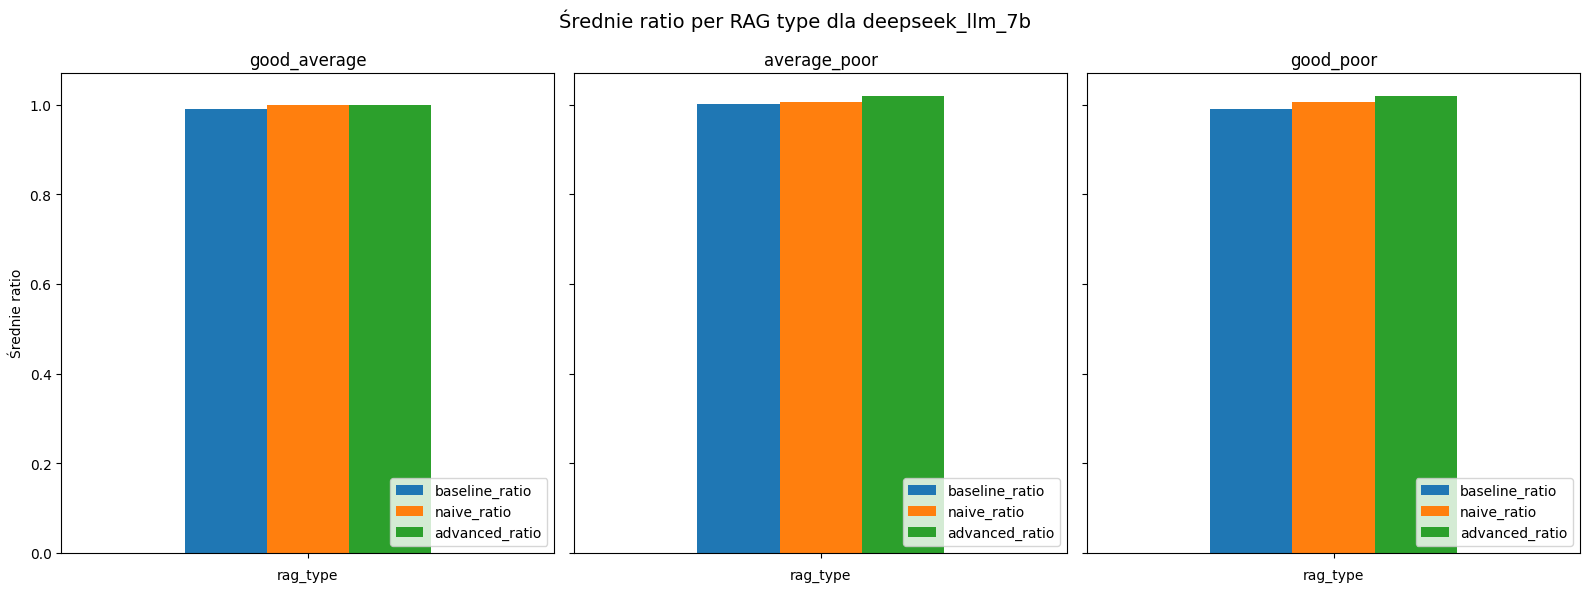

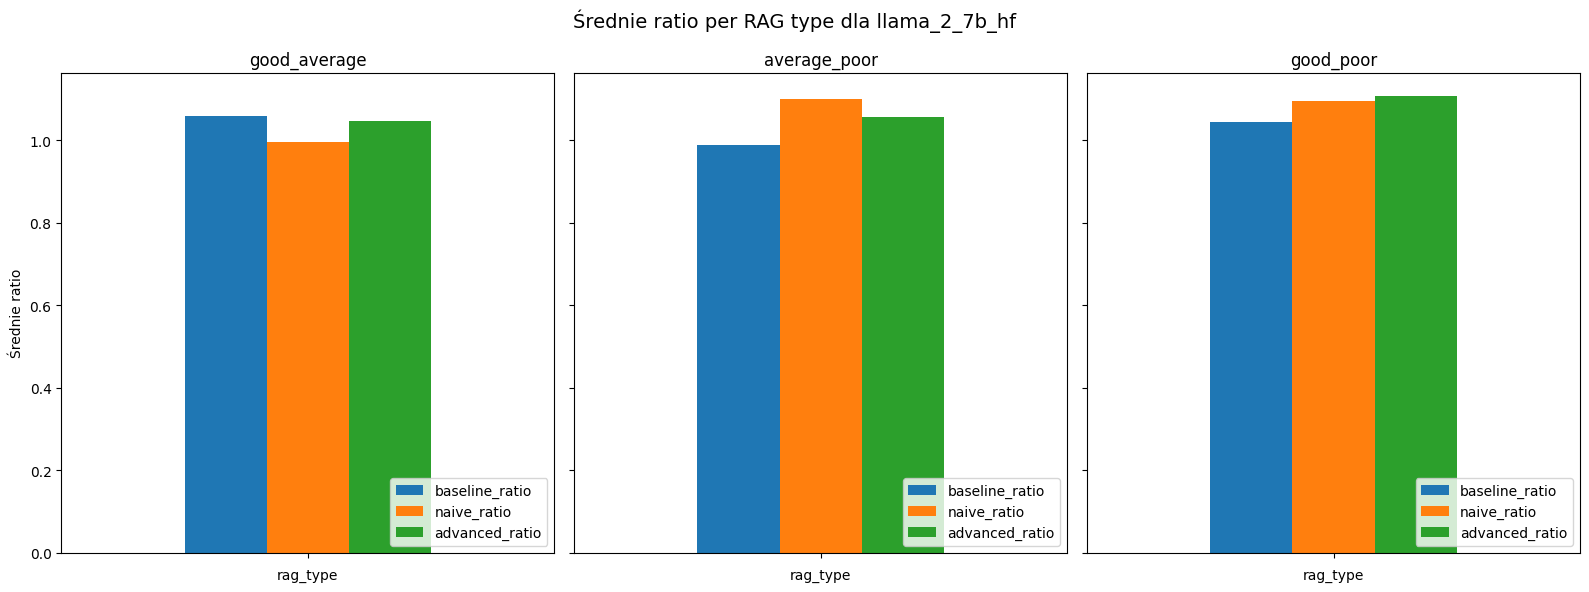

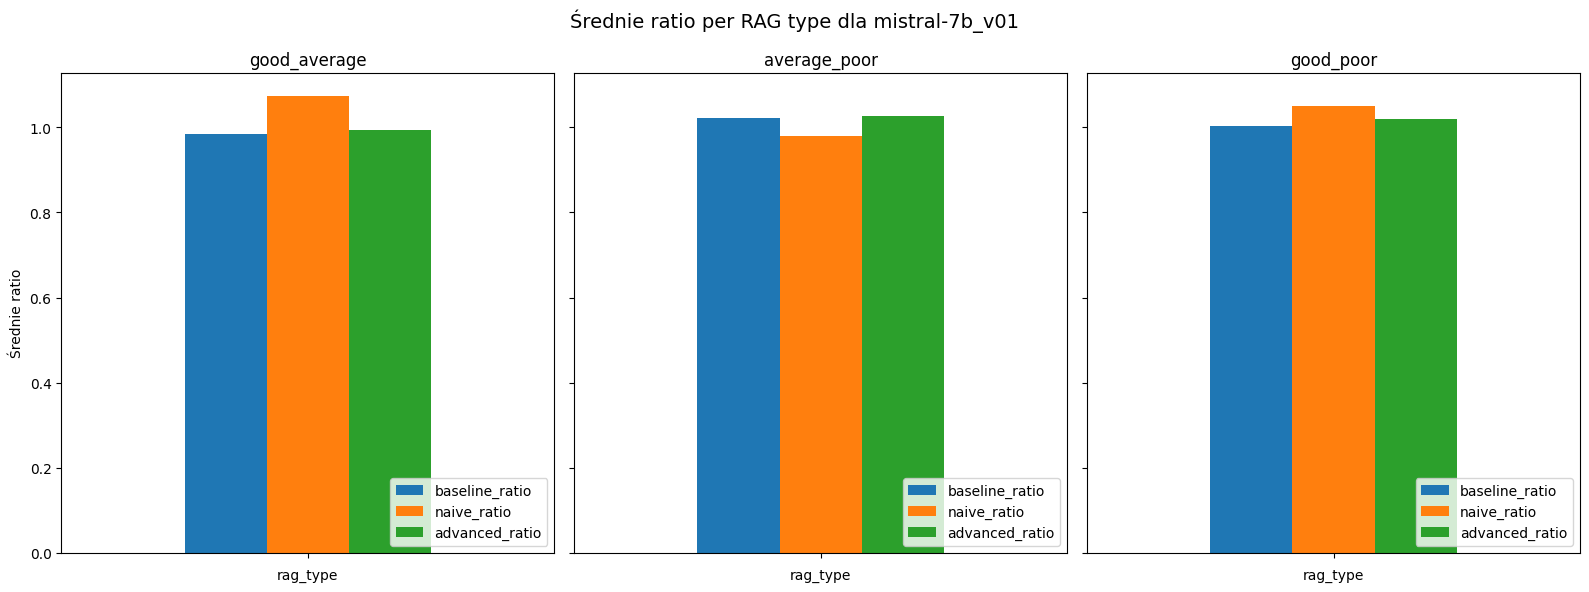

In [190]:
# ============================================
# 7. Wykresy dla wszystkich modeli – subploty,
# ============================================

unique_models = summary_df["model"].unique()

for model_to_plot in unique_models:
    
    plot_df = (
        summary_df[summary_df["model"] == model_to_plot]
        .groupby(["buckets"])
        .agg(
            baseline_ratio=("baseline_ratio", "mean"),
            naive_ratio=("naive_ratio", "mean"),
            advanced_ratio=("advanced_ratio", "mean"),
        )
        .reset_index()
    )
    
    fig, axes = plt.subplots(1, 3, figsize=(16, 6), sharey=True)
    fig.suptitle(f"Średnie ratio per RAG type dla {model_to_plot}", fontsize=14)
    
    bucket_order = ["good_average", "average_poor", "good_poor"]
    rag_cols = ["baseline_ratio", "naive_ratio", "advanced_ratio"]

    for i, bucket in enumerate(bucket_order):
        ax = axes[i]
        
        bucket_df = plot_df[plot_df["buckets"] == bucket]
        
        if bucket_df.empty:
            ax.set_title(f"{bucket}\n(brak danych)")
            ax.axis("off")
            continue
        
        bucket_df_indexed = bucket_df.set_index("buckets")[rag_cols]
        bucket_df_indexed.plot(kind="bar", ax=ax)

        ax.set_title(bucket)
        ax.set_ylabel("Średnie ratio")
        ax.set_xlabel("rag_type")
        ax.set_xticklabels([])
        ax.legend(loc="lower right")

    plt.tight_layout()
    plt.show()


In [193]:
import json
import os
import pandas as pd

BUCKET_DIR = "C:/Users/user/Desktop/pb_msc/memorization_score/results/buckets"

models = ["deepseek_llm_7b", "llama_2_7b_hf", "mistral-7b_v01"]

bucket_map = {
    "bucket_good.json": "good",
    "bucket_average.json": "average",
    "bucket_poor.json": "poor"
}


In [ ]:
rows = []

for model in models:
    model_dir = os.path.join(BUCKET_DIR, model)
    
    for fname in os.listdir(model_dir):
        if not fname.endswith(".json"):
            continue
        
        bucket_key = [bucket_map[k] for k in bucket_map if k in fname]
        if not bucket_key:
            continue
        bucket_name = bucket_key[0]
        
        path = os.path.join(model_dir, fname)
        with open(path, "r", encoding="utf-8") as f:
            data = json.load(f)
        
        for item in data["results"]:
            rows.append({
                "model": model,
                "bucket": bucket_name,
                "id": item["id"],
                "adjusted_perplexity": float(item["adjusted_perplexity"]),
                "token_count": int(item["token_count"])
            })

bucket_df = pd.DataFrame(rows)

print("Wczytano:", bucket_df.shape)

Wczytano: (900, 5)


,model,bucket,id,adjusted_perplexity,token_count
0,deepseek_llm_7b,average,8250,14.75,1024
1,deepseek_llm_7b,average,15566,11.16,1024
2,deepseek_llm_7b,average,12264,26.09,591
3,deepseek_llm_7b,average,5832,13.92,648
4,deepseek_llm_7b,average,8765,11.88,770


In [195]:
bucket_stats = (
    bucket_df
    .groupby(["model", "bucket"])
    .agg(
        samples=("id", "count"),
        mean_adjusted_ppl=("adjusted_perplexity", "mean"),
        median_adjusted_ppl=("adjusted_perplexity", "median"),
        std_adjusted_ppl=("adjusted_perplexity", "std"),
        
        mean_token_count=("token_count", "mean"),
        median_token_count=("token_count", "median"),
        std_token_count=("token_count", "std")
    )
    .reset_index()
)

bucket_stats


,model,bucket,samples,mean_adjusted_ppl,median_adjusted_ppl,std_adjusted_ppl,mean_token_count,median_token_count,std_token_count
0,deepseek_llm_7b,average,100,16.0583,13.995,5.399507,735.28,718.0,260.895508
1,deepseek_llm_7b,good,100,7.3112,7.545,1.724540,1002.51,1024.0,67.588848
2,deepseek_llm_7b,poor,100,47.2040,41.595,17.664375,314.78,305.0,82.665027
3,llama_2_7b_hf,average,100,16.8524,15.600,5.421054,491.21,458.5,199.737418
4,llama_2_7b_hf,good,100,5.8238,5.865,1.726169,964.98,1024.0,134.411623
5,llama_2_7b_hf,poor,100,37.6672,35.355,7.630872,277.70,264.5,49.983128
6,mistral-7b_v01,average,100,15.9279,14.920,5.151062,517.23,457.5,223.613522
7,mistral-7b_v01,good,100,6.0137,5.955,1.814879,952.70,1024.0,153.810424
8,mistral-7b_v01,poor,100,38.2094,35.220,8.709053,277.04,266.0,50.679010


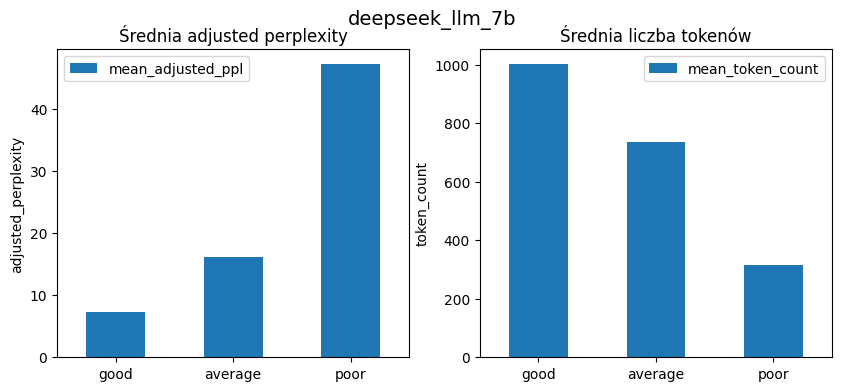

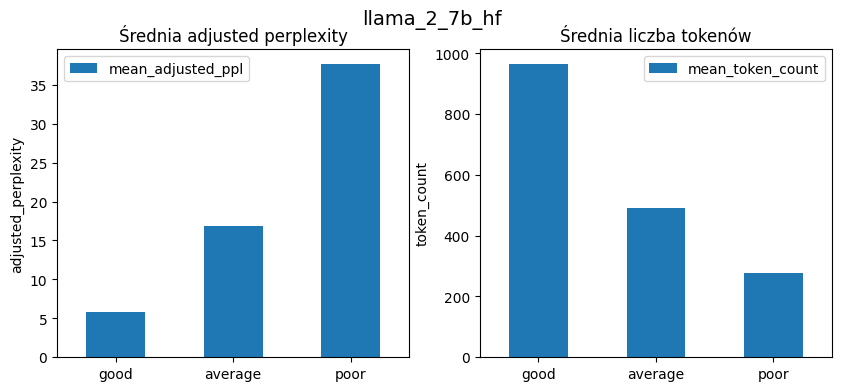

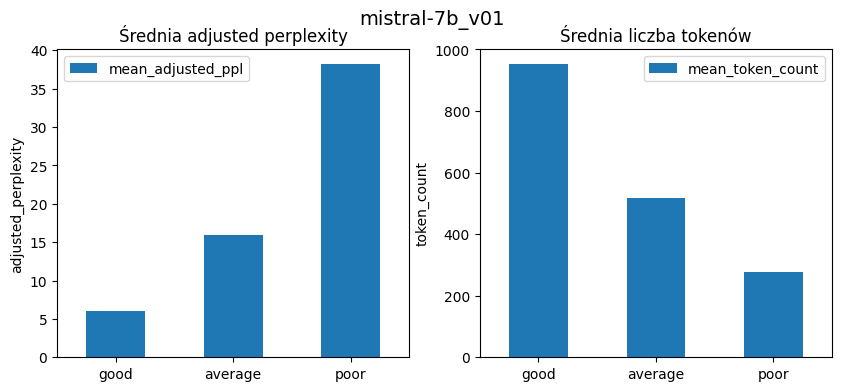

In [207]:
bucket_order = ["good", "average", "poor"]

for model in models:
    df_plot = (
        bucket_stats[bucket_stats["model"] == model]
        .set_index("bucket")
        .reindex(bucket_order)
    )
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True)
    fig.suptitle(f"{model}", fontsize=14)

    df_plot[["mean_adjusted_ppl"]].plot(
        kind="bar",
        ax=axes[0],
        title="Średnia adjusted perplexity"
    )
    axes[0].set_ylabel("adjusted_perplexity")
    axes[0].set_xlabel("")
    axes[0].tick_params(axis='x', rotation=0)

    df_plot[["mean_token_count"]].plot(
        kind="bar",
        ax=axes[1],
        title="Średnia liczba tokenów"
    )
    axes[1].set_ylabel("token_count")
    axes[1].set_xlabel("")
    axes[1].tick_params(axis='x', rotation=0)
